<a href="https://colab.research.google.com/github/LinaMariaCastro/curso-ia-para-economia/blob/main/clases/3_Analisis_y_visualizacion_datos/8_Mineria_de_texto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Inteligencia Artificial con Aplicaciones en Economía I**

- 👩‍🏫 **Profesora:** [Lina María Castro](https://www.linkedin.com/in/lina-maria-castro)  
- 📧 **Email:** [lmcastroco@gmail.com](mailto:lmcastroco@gmail.com)  
- 🎓 **Universidad:** Universidad Externado de Colombia - Facultad de Economía

# 📄 **Minería de texto y análisis de sentimientos**

**Objetivos de Aprendizaje**

Al finalizar este notebook, serás capaz de:

1.  **Comprender la importancia del texto como fuente de datos**.
2.  **Realizar el preprocesamiento de un documento de texto**: limpieza, normalización, tokenización y eliminación de palabras muy comunes que no aportan mucho significado (*stop words*).
3.  **Aplicar técnicas de análisis de frecuencia** para identificar los términos más relevantes en un texto.
4.  **Visualizar los resultados** de un análisis de texto mediante nubes de palabras para una interpretación rápida e intuitiva.
5.  **Realizar análisis de sentimientos** sobre comentarios de empresas en internet.

## Importar librerías

Necesitaremos algunas librerías clave para el Procesamiento de Lenguaje Natural (NLP) como `nltk` y `wordcloud`.

In [11]:
# Instalamos las librerías necesarias, si no las hemos instalado previamente
# %pip install nltk wordcloud scikit-learn

In [12]:
import os
import nltk
import re
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [13]:
# Descargamos componentes necesarios de NLTK (solo se ejecuta la primera vez)
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Mejorar visualización de los dataframes

In [14]:
# Que muestre todas las columnas
pd.options.display.max_columns = None
# En los dataframes, mostrar los float con dos decimales
pd.options.display.float_format = '{:,.2f}'.format

## El Corpus: Un Comunicado del Banco de la República

Usaremos como *corpus* (nuestro conjunto de documentos de texto) un comunicado de prensa real del Banco de la República de Colombia publicado el 5 de agosto: "Minutas BanRep: La Junta Directiva del Banco de la República decidió por mayoría mantener inalterada la tasa de interés de política monetaria en 9,25%".

Este tipo de documento es ideal porque su lenguaje tiene un impacto directo en las expectativas de los agentes económicos y en los mercados financieros.

Link del comunicado: https://www.banrep.gov.co/es/noticias/minutas-banrep-julio-2025

In [15]:
texto_banco_republica = """
Entre mayo y junio la inflación anual se redujo de 5,1% a 4,8%. Esta disminución fue impulsada por la moderación de la inflación de las canastas de alimentos y de regulados.  En el caso de alimentos su inflación cayó de 4,7% a 4,3%, debido principalmente a la reducción de la inflación de perecederos. En cuanto a los regulados, su inflación se redujo de 6,3% a 5,5%, jalonada por la menor inflación de servicios públicos, especialmente de energía eléctrica. La inflación básica (sin alimentos ni regulados) se estabilizó en 4,8%, interrumpiendo su tendencia descendente, como resultado de algunas alzas en bienes y servicios diversos. Las expectativas de inflación se mantuvieron por encima de la meta. En el caso de los analistas, según las encuestas de julio, éstas se sitúan en 4,7% y 3,8% en la mediana para finales de 2025 y 2026 respectivamente. Las expectativas obtenidas de los mercados de deuda pública muestran comportamientos mixtos.
La actividad económica continúa con el dinamismo observado en el primer trimestre cuando alcanzó un crecimiento de 2,7% anual. En efecto, el índice de seguimiento de la economía (ISE) presentó en mayo una variación anual del 2,7% liderado por las actividades terciarias. Otros indicadores como las ventas al por menor, la producción manufacturera, y la demanda de energía, también mostraron resultados positivos. Sobre esta base, el equipo técnico estima que en el segundo trimestre la actividad económica crecería a un ritmo anual de 2,7%, jalonado por una demanda interna que se expandiría 4,1%.
Las condiciones de financiamiento externo del país se mantienen restrictivas, en un entorno de elevada incertidumbre mundial por los conflictos en varias regiones del mundo; tensiones comerciales globales que no obstante se han moderado; y la lenta normalización esperada de la política monetaria en los Estados Unidos. Respecto a estas dos últimas, las recientes negociaciones comerciales entre los Estados Unidos y otras economías como China, Reino Unido y la Unión Europea han acordado aranceles más bajos que los inicialmente anunciados. De otra parte, en los Estados Unidos la Reserva Federal (Fed) mantuvo inalterada la tasa de interés de política monetaria entre el 4,25 % y 4,5 % en su sesión de julio.
Los directores de la Junta coincidieron en destacar el buen desempeño que la economía colombiana ha venido mostrando en lo corrido del año, caracterizado por una actividad económica dinámica y una reducción de la tasa de desempleo, en un contexto en el que el crédito comienza a mostrar tasas de crecimiento reales positivas. Resaltaron el fortalecimiento de la demanda interna impulsada principalmente por el consumo privado. Reconocieron que el ritmo de descenso de la inflación en la primera mitad de 2025 ha sido más lento que el esperado, en un entorno de choques de origen externo que han tornado las condiciones financieras internacionales especialmente restrictivas. Señalaron que el persistente desajuste fiscal crea retos importantes para el país. En estas condiciones, cuatro miembros de la Junta se inclinaron por mantener inalterada la tasa de interés de política en 9,25%, dos de ellos votaron por una reducción de 50 pbs, y uno por un recorte de 25 pbs.

Los miembros del grupo mayoritario señalaron que la reducción de la inflación anual observada en junio y las perspectivas sobre su trayectoria en los próximos meses, no crean las condiciones propicias para proceder con un recorte de la tasa de interés de política. Advierten que se trató de un resultado de origen puntual que no asegura la convergencia de la inflación hacia la meta del 3% en un horizonte prudente. Al respecto, anotaron que la inflación básica (sin alimentos ni regulados) se mantuvo inalterada en junio, y que las expectativas de inflación para fines de 2025 y 2026 medidas en julio no se redujeron con respecto a las que existían en mayo. El equipo técnico proyecta una inflación total y básica de 4,7% y 4,2% para 2025 y de 3,2% y 3,3% para 2026 respectivamente. No obstante, estos directores resaltaron que se vislumbran riesgos inflacionarios a corto plazo de llegarse a presentar faltantes de financiamiento del déficit fiscal o de la cuenta corriente de la balanza de pagos que presionen al alza la tasa de cambio. Añadieron que un incremento sustancial del salario mínimo para 2026 en línea con lo ocurrido en años anteriores constituiría nuevamente un obstáculo para acercarse a la meta de inflación. Con respecto al panorama fiscal, subrayaron que el mayor déficit del Gobierno Central previsto para 2025 y para 2026 genera un impulso macroeconómico que se reflejaría en mayores presiones inflacionarias y en un incremento adicional a la ya alta prima de riesgo país. Señalaron que el favorable desempeño macroeconómico en materia de crecimiento y empleo de la primera mitad del año reduce los dilemas de política monetaria, lo cual permite que ésta se enfoque en el objetivo de buscar la convergencia de la inflación a la meta, mediante decisiones cautelosas sobre la tasa de interés, sin grandes sacrificios económicos a corto plazo y con la perspectiva de lograr la estabilidad de precios. Insistieron en que la inflación constituye un impuesto altamente regresivo que afecta desproporcionadamente a los hogares en condición de pobreza y en que los países que han consolidado la estabilidad de precios tienden a registrar mayores tasas de crecimiento, en buena medida porque logran mantener tasas de interés reales más bajas en el tiempo.

Los directores que votaron por una reducción de 50 pbs sostienen que la tasa de interés real de política monetaria descontando la inflación observada (tasa ex-post), del último año y medio (de enero del 2024 a junio del 2025) es 9,2 veces superior al promedio entre enero del 2010 y diciembre del 2023. La primera fue de 4,15% y la segunda 0,45%. Agregan que actualmente ésta se ubica en 4,4%, la segunda más alta de la región después de Brasil. Basados en esta evidencia, señalan que la postura de política monetaria en Colombia es altamente restrictiva. En segundo término, consideran que los cálculos de variables inobservables, tales como la tasa de interés neutral; la brecha del PIB; y la brecha de desempleo, que el equipo técnico utiliza para respaldar sus recomendaciones a la Junta, son discutibles por estar basadas en resultados de modelos, que no pueden verificarse empíricamente.  Argumentan que la inflación anual se ubicó en 4,82% en junio, reduciéndose frente al registro de mayo (5,05%) y sorprendiendo a la baja a los analistas del mercado. Aunque aún se encuentra por encima del rango meta, la trayectoria descendente refuerza el espacio para continuar con la reducción de tasas. El equipo técnico de la Dirección General de Política Macroeconómica del Ministerio de Hacienda (DGPM) proyecta en su última actualización de supuestos macroeconómicos que la inflación se sitúe en 4,5% al cierre de 2025. Las expectativas de inflación para cierre de 2025 se ubican en 4,79% en julio, disminuyendo 2pbs frente a lo esperado el mes pasado (4,81%). Además, las expectativas a 12 y 24 meses se mantienen ancladas en el rango meta del Banco de la República, ubicándose en 3,79% y 3,49% respectivamente, lo que sugiere espacio para mantener la senda de recortes de la tasa de interés. La tasa de interés real se ubicaría en 4,6% en julio, 2,0pps por encima del nivel neutral estimado por el Banco de la República (2,6%). Dado que se espera que la inflación mantenga su senda decreciente durante el resto del año y que la brecha del producto se ubique en terreno negativo, se considera apropiado continuar implementando reducciones en la tasa de interés en las próximas reuniones de la JDBR. Insisten en que tasas de interés reales altas como las que actualmente se observan en Colombia afectan las posibilidades de crecimiento económico, y en particular el dinamismo del sector manufacturero, que requiere incentivos mayores, se considera que continuar con la trayectoria de reducciones en la tasa de interés favorecería el impulso del sector industrial sobre el crecimiento económico. Agregaron que una reducción de tasas de interés también ofrecería un estímulo importante para el microcrédito y la economía popular.  De igual forma sustentan que los incrementos en el salario mínimo real en los últimos tres años no han tenido los efectos inflacionarios insinuados y, por otro lado, han contribuido a la reducción de los indicadores de pobreza, como se evidencia en la tasa de desempleo decreciente y reducción de la pobreza monetaria. Para atender los desequilibrios fiscales es prioritario garantizar el mayor crecimiento de la economía y una ley de financiamiento que permita la sostenibilidad fiscal en el mediano plazo.

El director que votó por un recorte de 25 pbs considera que cumplir el mandato constitucional de controlar la inflación se realiza en el contexto de cumplir con el objetivo principal de la política económica que es mantener un crecimiento sostenido y aumentar el empleo, especialmente en un país muy desigual como Colombia. Concuerda en que si bien, la coyuntura fiscal es compleja, se distancia de las expectativas excesivamente negativas sobre un posible deterioro fiscal, y valora la transparencia del Gobierno en este campo. Subraya que, a pesar de la activación de la cláusula de escape de la regla fiscal y de la reducción de la calificación crediticia, la prima de riesgo ha venido disminuyendo en las últimas semanas, corrigiendo desviaciones previas, como lo muestra el reciente descenso del CDS. Adicionalmente, observa que la tasa de cambio ha permanecido en sendas por debajo de los 4.200 pesos, y converge a las variaciones de otros países de la región, dando con ello señales de estabilidad. Finalmente advierte que, si bien las variables macroeconómicas continúan en una senda positiva, la inversión privada disminuye en algunos sectores tradicionales, razón por la cual es importante dar señales que permitan dar confianza a la inversión, para lo cual la tasa de interés de política cumple una función esencial.
"""

## Preprocesamiento del Texto: La Limpieza de Datos

Este es el paso más importante. Un texto 'sucio' puede llevar a conclusiones erróneas. Seguiremos una rutina estándar:

### 1. Normalización

Convertir todo a minúsculas para que 'Inflación' e 'inflación' se traten como la misma palabra.

In [16]:
texto_limpio = texto_banco_republica.lower()
texto_limpio

'\nentre mayo y junio la inflación anual se redujo de 5,1% a 4,8%. esta disminución fue impulsada por la moderación de la inflación de las canastas de alimentos y de regulados.  en el caso de alimentos su inflación cayó de 4,7% a 4,3%, debido principalmente a la reducción de la inflación de perecederos. en cuanto a los regulados, su inflación se redujo de 6,3% a 5,5%, jalonada por la menor inflación de servicios públicos, especialmente de energía eléctrica. la inflación básica (sin alimentos ni regulados) se estabilizó en 4,8%, interrumpiendo su tendencia descendente, como resultado de algunas alzas en bienes y servicios diversos. las expectativas de inflación se mantuvieron por encima de la meta. en el caso de los analistas, según las encuestas de julio, éstas se sitúan en 4,7% y 3,8% en la mediana para finales de 2025 y 2026 respectivamente. las expectativas obtenidas de los mercados de deuda pública muestran comportamientos mixtos.\nla actividad económica continúa con el dinamismo o

### 2. Limpieza de caracteres no alfabéticos

Usamos expresiones regulares para quitar puntuación y números.

re.sub(patrón, reemplazo, texto) → busca todas las coincidencias de un patrón regex en el texto y las reemplaza por el valor que le indiques.

En este caso:

- patrón = r'[^a-záéíóúñ\s]'

- reemplazo = '' (una cadena vacía → borra lo encontrado)

- texto = texto_limpio

Explicación del patrón r'[^a-záéíóúñ\s]':

- [] → define un conjunto de caracteres permitidos.

- ^ (dentro de []) → significa “no” (niega lo que sigue).

- a-z → letras minúsculas de la a a la z.

- áéíóúñ → se añaden explícitamente vocales con tilde y la ñ, comunes en español.

- \s → representa espacios en blanco (incluye espacio, tabulador, salto de línea).

In [17]:
texto_limpio = re.sub(r'[^a-záéíóúñ\s]', '', texto_limpio)
texto_limpio

'\nentre mayo y junio la inflación anual se redujo de  a  esta disminución fue impulsada por la moderación de la inflación de las canastas de alimentos y de regulados  en el caso de alimentos su inflación cayó de  a  debido principalmente a la reducción de la inflación de perecederos en cuanto a los regulados su inflación se redujo de  a  jalonada por la menor inflación de servicios públicos especialmente de energía eléctrica la inflación básica sin alimentos ni regulados se estabilizó en  interrumpiendo su tendencia descendente como resultado de algunas alzas en bienes y servicios diversos las expectativas de inflación se mantuvieron por encima de la meta en el caso de los analistas según las encuestas de julio éstas se sitúan en  y  en la mediana para finales de  y  respectivamente las expectativas obtenidas de los mercados de deuda pública muestran comportamientos mixtos\nla actividad económica continúa con el dinamismo observado en el primer trimestre cuando alcanzó un crecimiento 

### 3. Tokenización

Dividir el texto en una lista de palabras individuales (tokens).

In [18]:
tokens = word_tokenize(texto_limpio, 'spanish')
tokens

['entre',
 'mayo',
 'y',
 'junio',
 'la',
 'inflación',
 'anual',
 'se',
 'redujo',
 'de',
 'a',
 'esta',
 'disminución',
 'fue',
 'impulsada',
 'por',
 'la',
 'moderación',
 'de',
 'la',
 'inflación',
 'de',
 'las',
 'canastas',
 'de',
 'alimentos',
 'y',
 'de',
 'regulados',
 'en',
 'el',
 'caso',
 'de',
 'alimentos',
 'su',
 'inflación',
 'cayó',
 'de',
 'a',
 'debido',
 'principalmente',
 'a',
 'la',
 'reducción',
 'de',
 'la',
 'inflación',
 'de',
 'perecederos',
 'en',
 'cuanto',
 'a',
 'los',
 'regulados',
 'su',
 'inflación',
 'se',
 'redujo',
 'de',
 'a',
 'jalonada',
 'por',
 'la',
 'menor',
 'inflación',
 'de',
 'servicios',
 'públicos',
 'especialmente',
 'de',
 'energía',
 'eléctrica',
 'la',
 'inflación',
 'básica',
 'sin',
 'alimentos',
 'ni',
 'regulados',
 'se',
 'estabilizó',
 'en',
 'interrumpiendo',
 'su',
 'tendencia',
 'descendente',
 'como',
 'resultado',
 'de',
 'algunas',
 'alzas',
 'en',
 'bienes',
 'y',
 'servicios',
 'diversos',
 'las',
 'expectativas',
 'de

### 4. Eliminación de Stop Words

En procesamiento de lenguaje natural (PLN), las stop words son palabras muy comunes en un idioma que, por lo general, no aportan mucho significado y se eliminan antes de hacer un análisis de texto.

- Ejemplos en español:

  - artículos: el, la, los, las, un, una

  - preposiciones: en, de, con, para, por, sobre

  - pronombres y conectores: que, se, lo, y, o, pero, como

- ¿Por qué quitarlas?

Si estás construyendo una nube de palabras o entrenando un modelo de machine learning, esas palabras aparecen con muchísima frecuencia y pueden ocultar las palabras realmente relevantes (ej. comida, servicio, lento, delicioso).

- Ejemplo:

  - Frase original: "El servicio fue excelente y la comida deliciosa"

  - Después de eliminar stop words: "servicio excelente comida deliciosa"

Así se destacan las palabras que llevan la información importante.

In [19]:
stop_words_es = set(stopwords.words('spanish'))
stop_words_es

{'a',
 'al',
 'algo',
 'algunas',
 'algunos',
 'ante',
 'antes',
 'como',
 'con',
 'contra',
 'cual',
 'cuando',
 'de',
 'del',
 'desde',
 'donde',
 'durante',
 'e',
 'el',
 'ella',
 'ellas',
 'ellos',
 'en',
 'entre',
 'era',
 'erais',
 'eran',
 'eras',
 'eres',
 'es',
 'esa',
 'esas',
 'ese',
 'eso',
 'esos',
 'esta',
 'estaba',
 'estabais',
 'estaban',
 'estabas',
 'estad',
 'estada',
 'estadas',
 'estado',
 'estados',
 'estamos',
 'estando',
 'estar',
 'estaremos',
 'estará',
 'estarán',
 'estarás',
 'estaré',
 'estaréis',
 'estaría',
 'estaríais',
 'estaríamos',
 'estarían',
 'estarías',
 'estas',
 'este',
 'estemos',
 'esto',
 'estos',
 'estoy',
 'estuve',
 'estuviera',
 'estuvierais',
 'estuvieran',
 'estuvieras',
 'estuvieron',
 'estuviese',
 'estuvieseis',
 'estuviesen',
 'estuvieses',
 'estuvimos',
 'estuviste',
 'estuvisteis',
 'estuviéramos',
 'estuviésemos',
 'estuvo',
 'está',
 'estábamos',
 'estáis',
 'están',
 'estás',
 'esté',
 'estéis',
 'estén',
 'estés',
 'fue',
 'f

In [20]:
tokens_filtrados = [palabra for palabra in tokens if palabra not in stop_words_es]
tokens_filtrados

['mayo',
 'junio',
 'inflación',
 'anual',
 'redujo',
 'disminución',
 'impulsada',
 'moderación',
 'inflación',
 'canastas',
 'alimentos',
 'regulados',
 'caso',
 'alimentos',
 'inflación',
 'cayó',
 'debido',
 'principalmente',
 'reducción',
 'inflación',
 'perecederos',
 'cuanto',
 'regulados',
 'inflación',
 'redujo',
 'jalonada',
 'menor',
 'inflación',
 'servicios',
 'públicos',
 'especialmente',
 'energía',
 'eléctrica',
 'inflación',
 'básica',
 'alimentos',
 'regulados',
 'estabilizó',
 'interrumpiendo',
 'tendencia',
 'descendente',
 'resultado',
 'alzas',
 'bienes',
 'servicios',
 'diversos',
 'expectativas',
 'inflación',
 'mantuvieron',
 'encima',
 'meta',
 'caso',
 'analistas',
 'según',
 'encuestas',
 'julio',
 'éstas',
 'sitúan',
 'mediana',
 'finales',
 'respectivamente',
 'expectativas',
 'obtenidas',
 'mercados',
 'deuda',
 'pública',
 'muestran',
 'comportamientos',
 'mixtos',
 'actividad',
 'económica',
 'continúa',
 'dinamismo',
 'observado',
 'primer',
 'trimestr

In [21]:
print("--- Antes del preprocesamiento ---")
print(texto_banco_republica[:175] + "...")
print("\n--- Después del preprocesamiento (primeros 20 tokens) ---")
print(tokens_filtrados[:12])

--- Antes del preprocesamiento ---

Entre mayo y junio la inflación anual se redujo de 5,1% a 4,8%. Esta disminución fue impulsada por la moderación de la inflación de las canastas de alimentos y de regulados. ...

--- Después del preprocesamiento (primeros 20 tokens) ---
['mayo', 'junio', 'inflación', 'anual', 'redujo', 'disminución', 'impulsada', 'moderación', 'inflación', 'canastas', 'alimentos', 'regulados']


## Análisis de Frecuencia

Una vez que tenemos los tokens limpios, el análisis más directo es contar cuáles son los más frecuentes. Esto nos da una idea clara de los temas centrales del documento.

In [22]:
# Usamos FreqDist de NLTK para contar la frecuencia de cada token
freq = nltk.FreqDist(tokens_filtrados)

print("Las 10 palabras más frecuentes:")
display(freq.most_common(10))

Las 10 palabras más frecuentes:


[('inflación', 23),
 ('tasa', 16),
 ('interés', 14),
 ('reducción', 10),
 ('política', 10),
 ('crecimiento', 8),
 ('fiscal', 7),
 ('anual', 6),
 ('expectativas', 6),
 ('meta', 6)]

Ahora, visualicemos esto con una nube de palabras.

## Nube de palabras (Word Cloud)

Es una **herramienta de visualización de texto** que representa las palabras más frecuentes en un conjunto de datos textuales, donde el tamaño de cada palabra refleja su frecuencia o relevancia. Es muy útil como primer paso exploratorio y como recurso visual y comunicativo

Sirve para:

- Exploración rápida de texto: Permite tener una visión general de los temas más recurrentes en un documento, corpus de textos, redes sociales, encuestas abiertas, reseñas, etc.

- Identificación de patrones y temas clave: Destaca las palabras que más aparecen, ayudando a detectar tendencias, intereses o preocupaciones en un grupo de personas.

- Comunicación visual: Resume información textual de manera atractiva y comprensible para públicos no técnicos, útil en presentaciones o reportes.

- Detección preliminar de sesgos o errores: Si aparecen muchas palabras irrelevantes (ej. “el”, “la”, “que”), puede evidenciar la necesidad de limpieza de datos (stopwords, lematización).

In [23]:
texto_para_nube = " ".join(tokens_filtrados)
texto_para_nube

'mayo junio inflación anual redujo disminución impulsada moderación inflación canastas alimentos regulados caso alimentos inflación cayó debido principalmente reducción inflación perecederos cuanto regulados inflación redujo jalonada menor inflación servicios públicos especialmente energía eléctrica inflación básica alimentos regulados estabilizó interrumpiendo tendencia descendente resultado alzas bienes servicios diversos expectativas inflación mantuvieron encima meta caso analistas según encuestas julio éstas sitúan mediana finales respectivamente expectativas obtenidas mercados deuda pública muestran comportamientos mixtos actividad económica continúa dinamismo observado primer trimestre alcanzó crecimiento anual efecto índice seguimiento economía ise presentó mayo variación anual liderado actividades terciarias indicadores ventas menor producción manufacturera demanda energía mostraron resultados positivos base equipo técnico estima segundo trimestre actividad económica crecería r

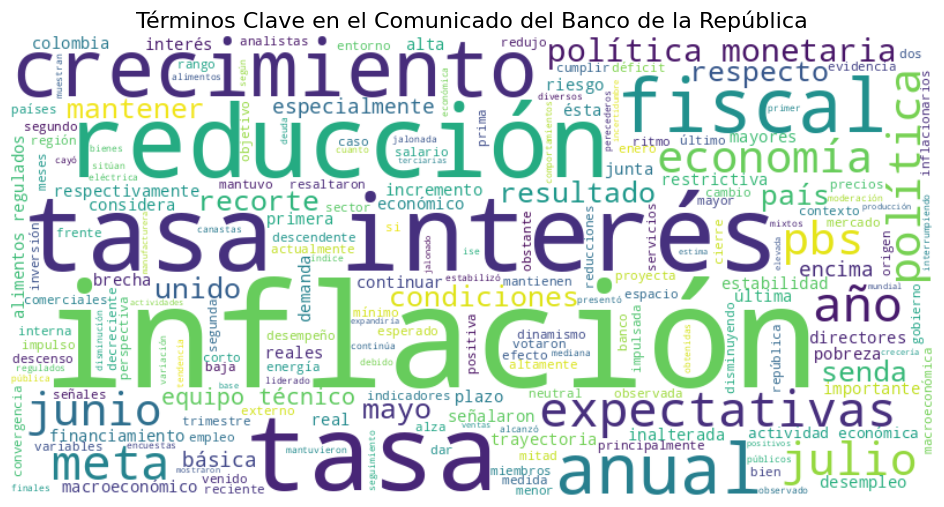

In [24]:
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(texto_para_nube)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Términos Clave en el Comunicado del Banco de la República', fontsize=16)
plt.show()

**Interpretación Económica:** La nube de palabras resalta instantáneamente los conceptos centrales, donde 'inflación', 'tasa', 'interés', 'crecimiento', 'reducción', son visiblemente los más importantes. Esto confirma, sin necesidad de leer el documento completo, que el comunicado trata sobre el trade-off entre controlar la inflación mediante la tasa de interés y su posible efecto en el crecimiento económico. Es una herramienta poderosa para el análisis rápido de sentimiento y enfoque de política.

## Ejercicio

Ahora vamos a modificar la lista de `stop_words` para incluir otras palabras que no agreguen mucho significado, y volvemos a generar la nube de palabras. ¿Qué términos ganan importancia una vez que eliminamos las otras palabras que hacían ruido?

In [25]:
# 1. Creamos una nueva lista de stop words extendida
stop_words_personalizada = set(stopwords.words('spanish'))
stop_words_personalizada.update(['junta', 'directiva', 'sesión', 'hoy', 'decidió', 'equipo', 'técnico', 'pbs',
                                 'respectivamente', 'resultado', 'considera', 'unido', 'anual', 'año',
                                 'especialmente', 'directores', 'tasa', 'ésta'])

In [26]:
# 2. Re-filtramos los tokens originales
tokens_originales = word_tokenize(re.sub(r'[^a-záéíóúñ\s]', '', texto_banco_republica.lower()), 'spanish')
tokens_filtrados_v2 = [palabra for palabra in tokens_originales if palabra not in stop_words_personalizada]

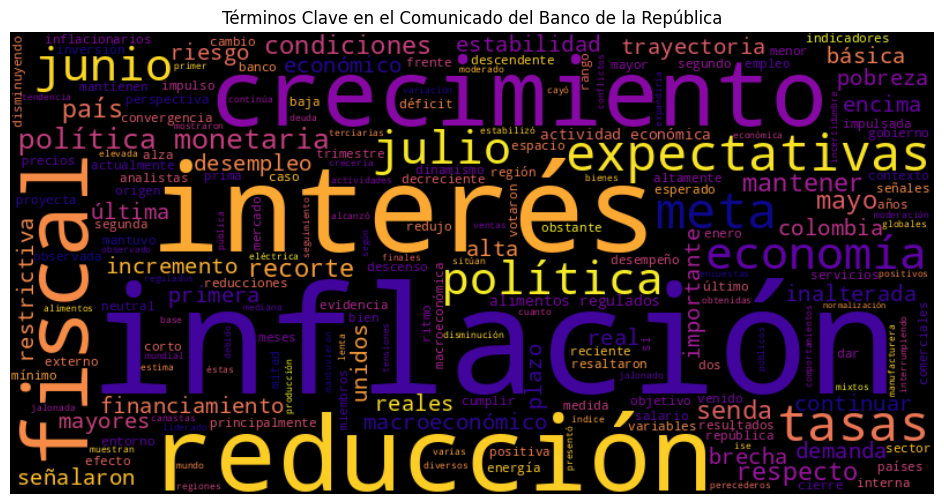

In [27]:
# 3. Generamos la nueva nube de palabras
texto_para_nube_v2 = " ".join(tokens_filtrados_v2)
wordcloud_v2 = WordCloud(width=800, height=400, background_color='black', colormap='plasma').generate(texto_para_nube_v2)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud_v2, interpolation='bilinear')
plt.axis("off")
plt.title('Términos Clave en el Comunicado del Banco de la República')
plt.show()

Al eliminar los términos institucionales, palabras como 'inflación', 'interés', 'crecimiento' y 'reducción' se vuelven más visibles. Esto nos ayuda a enfocarnos aún más en los conceptos claves del comunicado.

## Análisis de sentimientos

Vamos a trabajar con un conjunto de datos de reseñas en español.

Link: https://github.com/AlessandroGianfelici/spanish_reviews_dataset

Este conjunto de datos se ha recopilado de internet mediante técnicas de web scraping.

Para cada observación, el conjunto de datos contiene el nombre de la empresa (codificado por razones de privacidad), el título de la reseña, el texto de la reseña y el número de estrellas (de 1 a 5).

El dataset se encuentra en el repositorio del curso, carpeta 'datasets', archivo 'reviews_data.txt'

### Cargar el dataset

In [ ]:
from google.colab import drive, files
drive.mount('/content/drive')

In [ ]:
path = '/content/drive/MyDrive/2025_ii_curso_ia_economia/datasets'

In [ ]:
# Para establecer el directorio de los archivos
os.chdir(path)

In [ ]:
df = pd.read_csv('reviews_data.txt')
df

In [ ]:
df.info()

### Vamos a analizar las reseñas positivas de una sola compañía

In [ ]:
# Vamos a seleccionar una sola compañía y vamos a analizarsus reseñas
df_pos = df[(df['company_name']==-8121737614821815175) & (df['review_stars']>=4)]
df_pos

In [ ]:
df_pos['review_stars'].value_counts(normalize=True)

In [ ]:
# Concatenar todas las filas de la columna en un solo texto
texto_pos = " ".join(df_pos["review_text"])
texto_pos


In [ ]:
# 1. Normalización: Convertir todo a minúsculas para que 'Inflación' e 'inflación' se traten como la misma palabra.
texto_limpio = texto_pos.lower()

# 2. Limpieza de caracteres no alfabéticos: Usamos expresiones regulares para quitar puntuación y números.
texto_limpio = re.sub(r'[^a-záéíóúñ\s]', '', texto_limpio)

# 3. Tokenización: Dividir el texto en una lista de palabras individuales (tokens).
tokens = word_tokenize(texto_limpio, 'spanish')

# 4. Eliminación de Stop Words: Quitar palabras comunes en español que no aportan significado económico.
stop_words_es = set(stopwords.words('spanish'))

tokens_filtrados = [palabra for palabra in tokens if palabra not in stop_words_es]

In [ ]:
# Usamos FreqDist de NLTK para contar la frecuencia de cada token
freq = nltk.FreqDist(tokens_filtrados)

print("Las 10 palabras más frecuentes:")
display(freq.most_common(10))

In [ ]:
# 1. Creamos una nueva lista de stop words extendida
stop_words_personalizada = set(stopwords.words('spanish'))
stop_words_personalizada.update(['camping', 'bungalow', 'bungalows', 'allcamps'])

# 2. Re-filtramos los tokens originales
tokens_originales = word_tokenize(re.sub(r'[^a-záéíóúñ\s]', '', texto_pos.lower()), 'spanish')
tokens_filtrados_v2 = [palabra for palabra in tokens_originales if palabra not in stop_words_personalizada]

In [ ]:
# Ahora, visualicemos esto con una nube de palabras.
# La nube de palabras es excelente para presentaciones, ya que resume el contenido de forma visual e impactante.
texto_para_nube = " ".join(tokens_filtrados_v2)

In [ ]:
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(texto_para_nube)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Reseñas positivas', fontsize=16)
plt.show()

### Ahora, vamos a analizar las reseñas negativas

In [ ]:
df_neg = df[(df['company_name']==-8121737614821815175) & (df['review_stars']<=2)]
df_neg

In [ ]:
df_neg['review_stars'].value_counts(normalize=True)

In [ ]:
# Concatenar todas las filas de la columna en un solo texto
texto_neg = " ".join(df_neg["review_text"])
texto_neg


In [ ]:
# 1. Normalización: Convertir todo a minúsculas para que 'Inflación' e 'inflación' se traten como la misma palabra.
texto_limpio = texto_neg.lower()

# 2. Limpieza de caracteres no alfabéticos: Usamos expresiones regulares para quitar puntuación y números.
texto_limpio = re.sub(r'[^a-záéíóúñ\s]', '', texto_limpio)

# 3. Tokenización: Dividir el texto en una lista de palabras individuales (tokens).
tokens = word_tokenize(texto_limpio, 'spanish')

# 4. Eliminación de Stop Words: Quitar palabras comunes en español que no aportan significado económico.
stop_words_es = set(stopwords.words('spanish'))

tokens_filtrados = [palabra for palabra in tokens if palabra not in stop_words_es]

In [ ]:
# Usamos FreqDist de NLTK para contar la frecuencia de cada token
freq = nltk.FreqDist(tokens_filtrados)

print("Las 10 palabras más frecuentes:")
display(freq.most_common(10))

In [ ]:
# 1. Creamos una nueva lista de stop words extendida
stop_words_personalizada = set(stopwords.words('spanish'))
stop_words_personalizada.update(['camping', 'bungalow', 'bungalows', 'si', 'allcamps'])

# 2. Re-filtramos los tokens originales
tokens_originales = word_tokenize(re.sub(r'[^a-záéíóúñ\s]', '', texto_neg.lower()), 'spanish')
tokens_filtrados_v2 = [palabra for palabra in tokens_originales if palabra not in stop_words_personalizada]

In [ ]:
# Ahora, visualicemos esto con una nube de palabras.
# La nube de palabras es excelente para presentaciones, ya que resume el contenido de forma visual e impactante.
texto_para_nube = " ".join(tokens_filtrados_v2)

In [ ]:
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(texto_para_nube)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Reseñas negativas', fontsize=16)
plt.show()

### Análisis de sentimientos con un modelo preentrenado de redes neuronales

**Hugging Face** es el ecosistema más usado actualmente para acceder, usar y compartir **modelos de IA preentrenados**. Lo hace tan sencillo que con unas pocas líneas de código ya puedes aplicar análisis de sentimientos, traducción, chatbots, clasificación de texto y mucho más.

Un modelo preentrenado de HuggingFace para análisis de sentimientos en español es una red neuronal de lenguaje natural (NLP) que ya fue entrenada previamente con millones de textos en español. Por eso, en lugar de partir de cero, podemos aprovechar su conocimiento del idioma y de cómo se expresan emociones.

El entrenamiento se hace con datasets grandes de reseñas, tweets o comentarios que ya tienen una etiqueta de sentimiento (positivo, negativo, neutral).

Lo interesante es que el modelo no solo busca palabras individuales (como "bueno", "excelente",...), sino que entiende contexto, negaciones, sarcasmo y combinaciones de palabras.

En la práctica, lo usamos cargándolo con transformers (HuggingFace) y con una sola línea ya puede clasificar cada comentario en positivo/negativo/neutral sin necesidad de entrenar nada adicional.

In [ ]:
from transformers import pipeline

In [ ]:
# Cargar un modelo multilingüe de sentimientos
analisis = pipeline("sentiment-analysis", model="nlptown/bert-base-multilingual-uncased-sentiment")

In [ ]:
df_empresa = df[(df['company_name']==-8121737614821815175)]

In [ ]:
# Aplicar a cada comentario
df_empresa["puntaje"] = df_empresa["review_text"].apply(lambda x: analisis(x)[0]["label"])

In [ ]:
df_empresa.head()

Este modelo devuelve etiquetas tipo “1 star” a “5 stars”, que puedes mapear a:

1–2 estrellas → negativo

3 estrellas → neutral

4–5 estrellas → positivo

In [ ]:
df_empresa["puntaje"].value_counts()

In [ ]:
def clasificar(puntaje):
    if puntaje == '5 stars' or puntaje == '4 stars':
        return "positivo"
    elif puntaje == '3 stars':
        return "neutral"
    else:
        return "negativo"

df_empresa["sentimiento"] = df_empresa["puntaje"].apply(clasificar)

In [ ]:
sns.countplot(x="sentimiento", data=df_empresa)
plt.title("Distribución del sentimiento de los comentarios")
plt.show()